In [309]:
# -------
# IMPORT LIBRAIRIES
# -------
import numpy as np
import pandas as pd
import plotly.express as px
from python_module.pricing_model import SABRModel
from python_module.tools import maximize_with_bounds

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.options.display.float_format = '{:,.2f}'.format

In [310]:
# -------
# INPUTS
# -------

# Pricing parameters
F     = 5000
alpha = 0.25
beta  = 1.0
rho   = -0.5
nu    = 1.5
r     = 0
atm_bd = 5
tail_bd = 5

# Scenario parameters
scenario_min = -0.3
scenario_max = 0.3
scenario_step = 0.05

option_strikes = [-0.3, 0.3]
flat_scenarios = [-0.3, 0.3]

In [311]:
# Scenario parameters
num = int((scenario_max-scenario_min)/0.01 + 1)
slide_to_compute = list(np.round(np.linspace(start=scenario_min, stop=scenario_max, num=num), 2))

# Option portfolio
market_data_list = list()

# Option ATM
K = F
T = atm_bd / 250
option_type = 'call' if K >= F else 'put'
market_pricing_results = SABRModel.compute_option(F, K, T, alpha, beta, rho, nu, r, option_type, slide_list=slide_to_compute)
market_data_list.append({
    'symbol': f"{atm_bd}T_{K}K_{option_type}",
    'option_type': option_type, 
    'time_to_maturity': atm_bd, 
    'F':F, 'r': r, 'K': K, 'T': T, 'K/F': (K/F) - 1 ,**market_pricing_results})

for strike in option_strikes:
    K = F * (1+strike)
    T = tail_bd / 250
    option_type = 'call' if K >= F else 'put'
    market_pricing_results = SABRModel.compute_option(F, K, T, alpha, beta, rho, nu, r, option_type, slide_list=slide_to_compute)
    market_data_list.append({
        'symbol': f"{tail_bd}T_{K}K_{option_type}",
        'option_type': option_type, 
        'time_to_maturity': tail_bd, 
        'F':F, 'r': r, 'K': K, 'T': T, 'K/F': (K/F) - 1 ,**market_pricing_results})

market_data_df = pd.DataFrame(market_data_list)
market_data_df = market_data_df.set_index('symbol')

In [312]:
# ATM Scenarios
atm_market_data = market_data_df.loc[market_data_df['F']==market_data_df['K']]
atm_qty = -50000 / atm_market_data['theta']
atm_scenario = atm_market_data.loc[:, ['theta'] + slide_to_compute]
atm_scenario = atm_scenario.drop(0, axis=1)
atm_scenario.rename(columns={'theta': 0}, inplace=True)
atm_scenario = atm_scenario.sort_index(axis=1)
atm_scenario = atm_scenario.multiply(atm_qty, axis=0)
atm_scenario = atm_scenario.iloc[0].transpose()
target_hedge_portfolio_scenario = atm_scenario*-1

In [313]:
# OTM Scenarios
otm_market_data = market_data_df.loc[market_data_df['F']!=market_data_df['K']]
otm_scenario = otm_market_data.loc[:, ['theta'] + slide_to_compute]
otm_scenario = otm_scenario.drop(0, axis=1)
otm_scenario.rename(columns={'theta': 0}, inplace=True)
otm_scenario = otm_scenario.sort_index(axis=1)
otm_scenario = otm_scenario.transpose()

In [314]:
X = otm_scenario.loc[flat_scenarios].values
b = target_hedge_portfolio_scenario.loc[flat_scenarios].values
w = np.linalg.solve(X, b)
weights = pd.Series(w, index=otm_market_data.index)
print(weights)

symbol
5T_3500.0K_put     -52,068.61
5T_6500.0K_call   -515,379.15
dtype: float64


In [315]:
total_scenario = atm_scenario + (otm_scenario * weights).sum(axis=1)

In [316]:
total_scenario = total_scenario*(-50000/total_scenario.loc[0])

In [317]:
test = atm_scenario-total_scenario

In [318]:
test

-0.30   4,885,682.19
-0.29   3,707,034.11
-0.28   2,742,384.31
-0.27   1,976,112.62
-0.26   1,385,868.09
-0.25     945,281.31
-0.24     626,728.72
-0.23     403,707.09
-0.22     252,545.06
-0.21     153,367.46
-0.20      90,384.70
-0.19      51,673.76
-0.18      28,648.19
-0.17      15,395.73
-0.16       8,016.43
-0.15       4,042.15
-0.14       1,972.57
-0.13         930.96
-0.12         424.57
-0.11         186.91
-0.10          79.32
-0.09          32.39
-0.08          12.69
-0.07           4.75
-0.06           1.68
-0.05           0.55
-0.04           0.16
-0.03           0.04
-0.02           0.00
-0.01          -0.00
0.00            0.00
0.01           -0.00
0.02           -0.01
0.03           -0.01
0.04           -0.03
0.05           -0.04
0.06           -0.06
0.07           -0.08
0.08           -0.10
0.09           -0.11
0.10           -0.13
0.11           -0.15
0.12           -0.17
0.13           -0.19
0.14           -0.21
0.15           -0.23
0.16           -0.25
0.17         

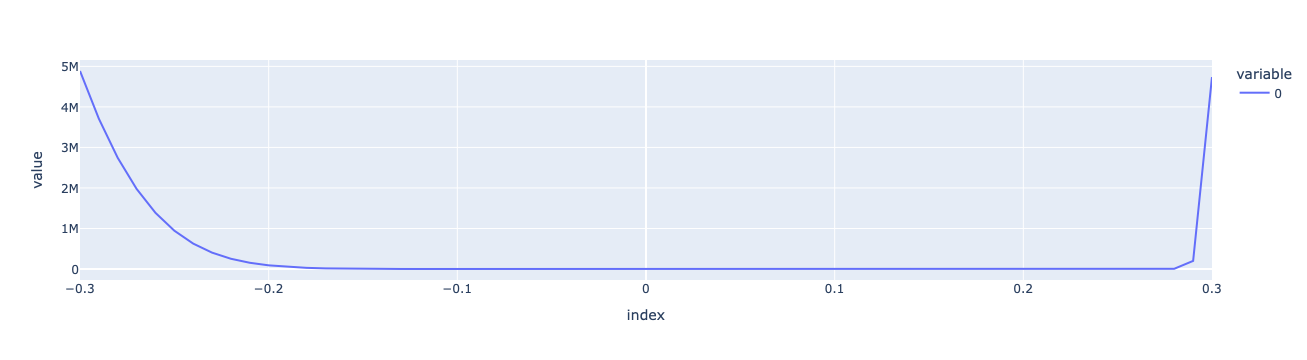

In [319]:
px.line(test)

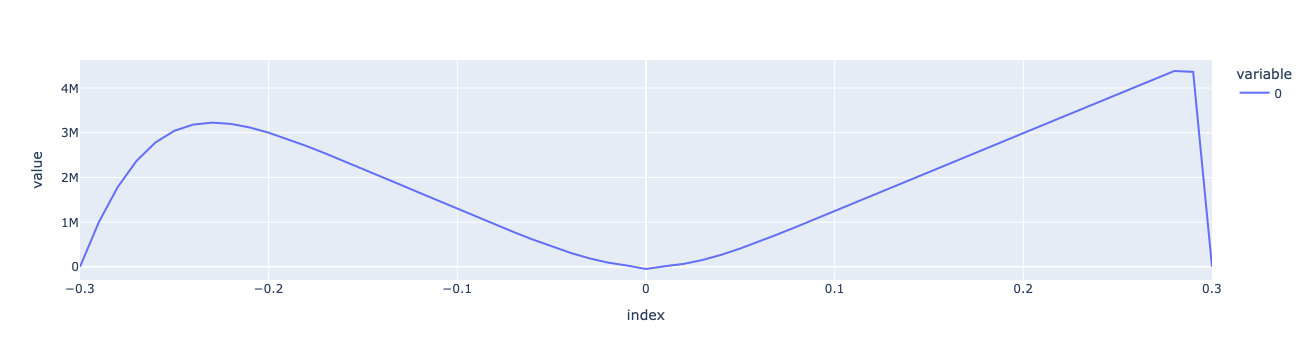

In [320]:
px.line(total_scenario)

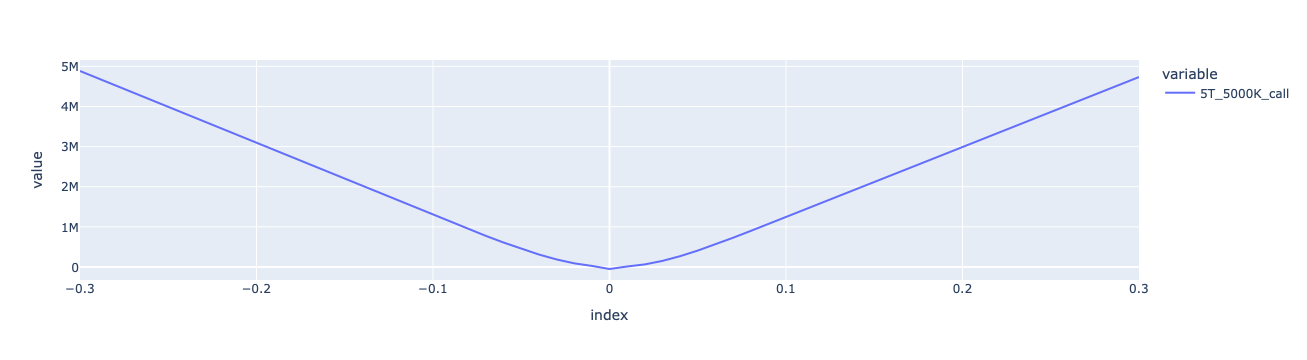

In [321]:
px.line(atm_scenario)